In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [14, 8]

In [18]:
df = pd.read_csv("BTC_USD.csv")[["Date", "Value"]]
df.Date = pd.to_datetime(df.Date)
df.sort_values(by="Date", inplace = True)
genesis = df.Date[len(df)-1]
#Genesis block is 3rd Jan, 2009, above value is actually 2nd Jan
df = df[df.Date >= "2010-09-16"]#useful data from exchanges from 2011 onwards
df=df.reset_index()
df=df.drop("index", axis=1)
delta = (df.Date[0] - genesis).days - 1
#728 days between Jan 1, 2011 and Jan 3, 2009

In [19]:
(df.Date[0] - genesis).days

622

In [20]:
df["ind"] = [x+delta for x in range(len(df))]
df #index represents number of days since genesis block

,Date,Value,ind
0,2010-09-16,0.150000,621
1,2010-09-17,0.060900,622
2,2010-09-18,0.062599,623
3,2010-09-19,0.060000,624
4,2010-09-20,0.063300,625
...,...,...,...
4047,2021-10-15,57397.740000,4668
4048,2021-10-16,61641.170000,4669
4049,2021-10-17,60948.780000,4670
4050,2021-10-18,61546.210000,4671


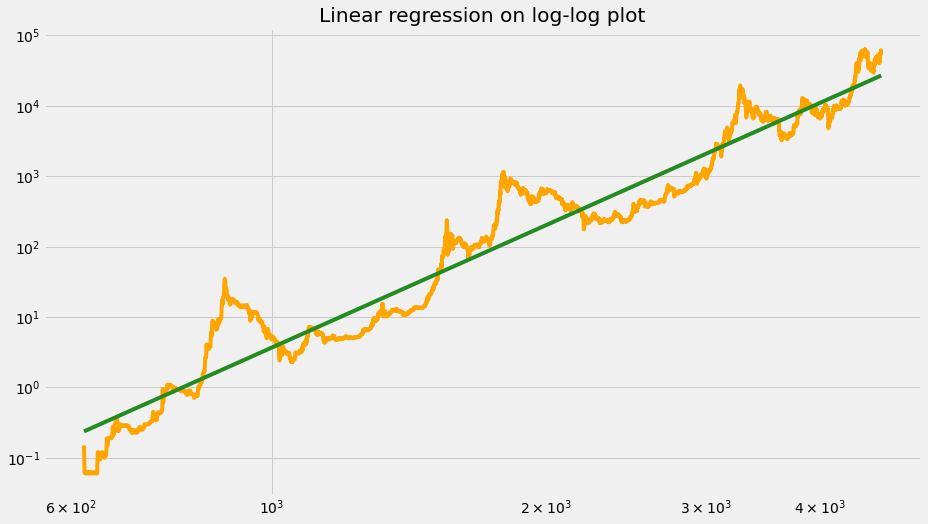

In [21]:
plt.style.use("fivethirtyeight")
plt.loglog(df.ind, df.Value, color = "orange") #plots ind and Value on log axes (values aren't log)

#linear regression - but based on the log-log graph so need to take log of values first 
X = np.array(np.log10(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
y = np.array(np.log10(df.Value))

#now X and y are how they look on a log-log chart
reg = LinearRegression().fit(X,y)


#remember plt plots on a linear axis and our X and y have been "logged"
plt.plot(np.power(10,X), np.power(10,reg.predict(X)), color = "forestgreen") #plot the X and predicted y as per X
plt.title("Linear regression on log-log plot")
plt.show()

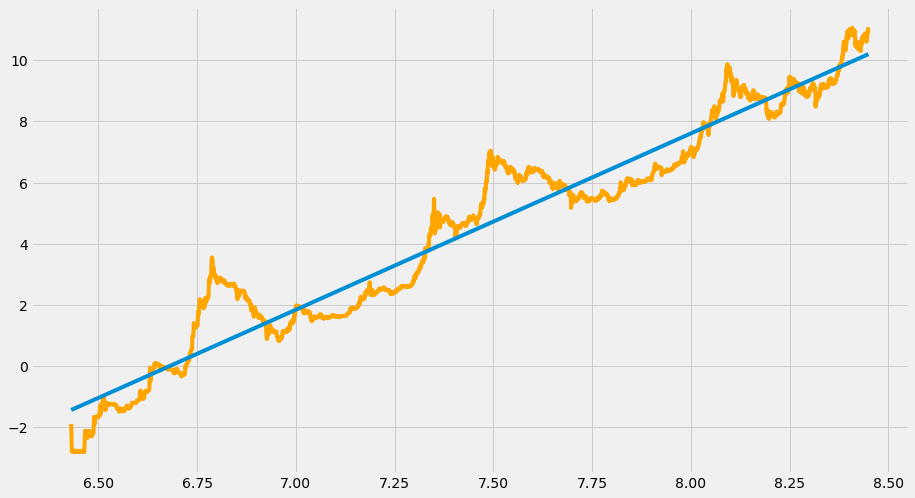

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(np.log(df.ind), np.log(df.Value), color = "orange") #plots ind and Value on log axes (values aren't log)

#linear regression - but based on the log-log graph so need to take log of values first 
X = np.array(np.log(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
y = np.array(np.log(df.Value))

#now X and y are how they look on a log-log chart
reg = LinearRegression().fit(X,y)

#remember plt plots on a linear axis and our X and y have been "logged"
plt.plot((X), (reg.predict(X))) #plot the X and predicted y as per X
plt.show()

In [23]:
def get_value(days):
    df1 = df[:days]
    X = np.array(np.log10(df1.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
    y = np.array(np.log10(df1.Value))

    #now X and y are how they look on a log-log chart
    reg = LinearRegression().fit(X,y)
    #now need the difference between price(in log form) and output
    return (reg.predict(X)[-1]) 


In [24]:
oss_values = np.log10(df.Value) - [get_value(x+1) for x in range(len(df))]
oss_values = list(oss_values)

<class 'list'>
1174 0.9618260883557936


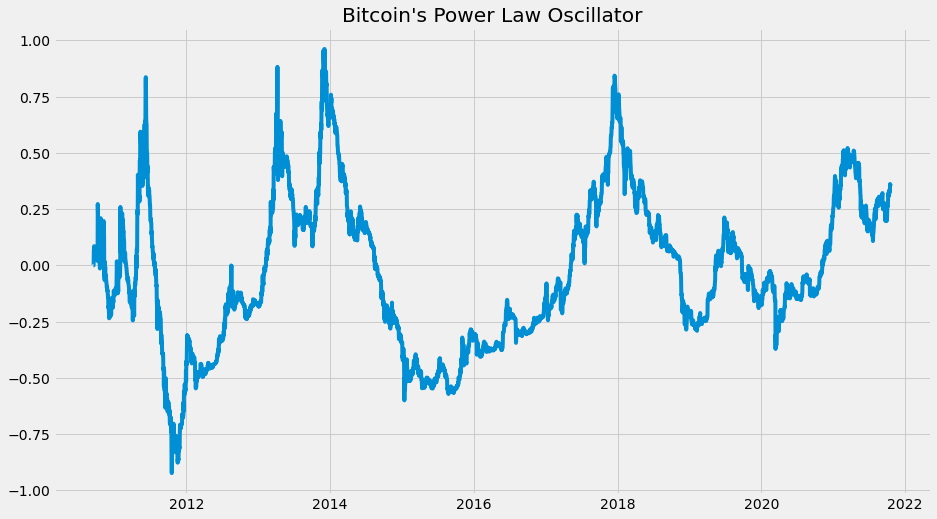

In [25]:
print(type(oss_values))
plt.plot(df.Date, oss_values)
plt.title("Bitcoin's Power Law Oscillator")
#plt.plot(df.Date, df.Value)
print(oss_values.index(max(oss_values)), max(oss_values))

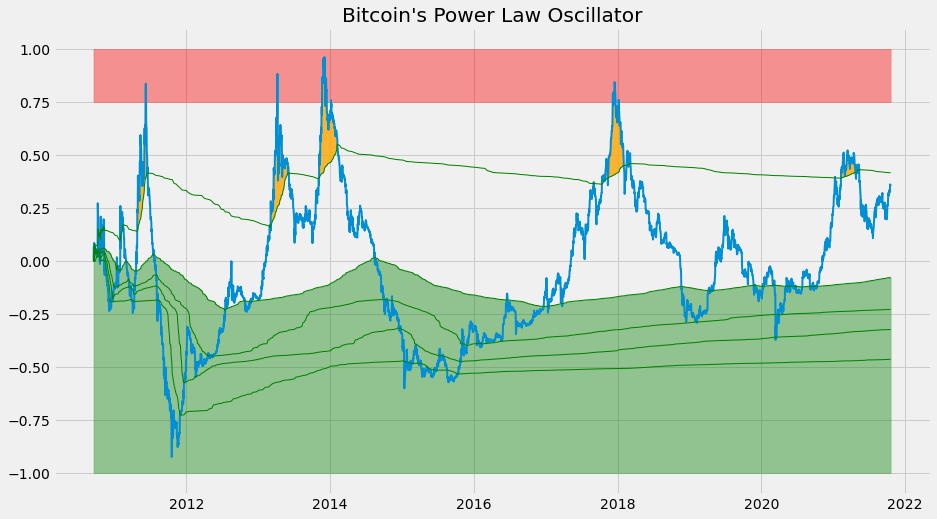

In [26]:
#add percentiles

df["ossvalues"] = oss_values
df["10cent"] = df["ossvalues"].expanding().quantile(0.1)
df["20cent"] = df["ossvalues"].expanding().quantile(0.2)
df["30cent"] = df["ossvalues"].expanding().quantile(0.3)
df["50cent"] = df["ossvalues"].expanding().quantile(0.5)
df["90cent"] = df["ossvalues"].expanding().quantile(0.9)

plt.title("Bitcoin's Power Law Oscillator")
plt.plot(df.Date, oss_values, linewidth=2)
plt.plot(df.Date, df["10cent"], color="green", linewidth=1)
plt.plot(df.Date, df["20cent"], color="green", linewidth=1)
plt.plot(df.Date, df["30cent"], color="green", linewidth=1)
plt.plot(df.Date, df["50cent"], color="green", linewidth=1)
plt.plot(df.Date, df["90cent"], color="green", linewidth=1)

plt.fill_between(df.Date, -1, df["50cent"], color="green", alpha=0.4) #(x_values, line #1, line #2, color)
plt.fill_between(df.Date, 0.75, 1, color="red", alpha=0.4)
plt.fill_between(df.Date, oss_values, df["90cent"], color="orange", where = list(oss_values > df["90cent"]), alpha=0.8)

In [27]:
def get_furthest_x(y, line):
    #y is all the log of values 
    # line is the linear regression line
    difference = [abs(y[x] - line[x]) for x in range(len(line))]
    max_difference = max(difference)
    return difference.index(max_difference)

In [28]:
def perform_regression(df):
    X = np.array(np.log(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
    y = np.array(np.log(df.Value))

    #now X and y are how they look on a log-log chart
    reg = LinearRegression().fit(X,y)

    #remember plt plots on a linear axis and our X and y have been "logged"
    #plt.plot((X), (reg.predict(X))) #plot the X and predicted y as per X
    line = reg.predict(X)
    outlier = get_furthest_x(y, line) #index of furthest element from line
    return outlier

In [29]:
df2 = df
iterations = int(len(df2)/2)
print(iterations)
for i in range(0,iterations):
    outlier = perform_regression(df2)
    #outlier is the xth index from beginning, we need to drop it
    df2=df2.drop(df2.index[outlier])

2026


Text(0.5, 1.0, 'RANSAC non-bubble data')

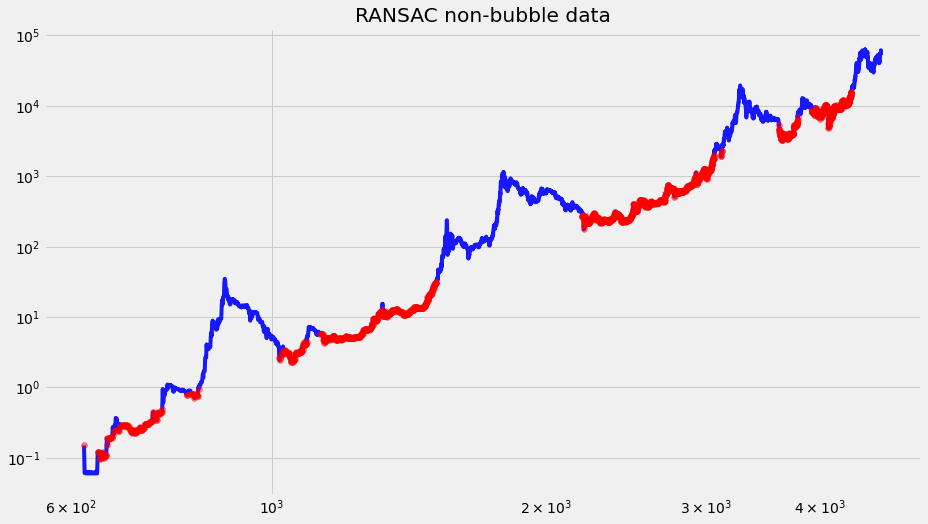

In [30]:
plt.loglog(df.ind, df.Value, alpha=0.9, color="blue", zorder=1)
plt.scatter(df2.ind, df2.Value, color='red', alpha=0.5, zorder=2)
plt.title("RANSAC non-bubble data")